In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yanhu/data/PRINT/multiScaleFootprinting/code")
import time
import pandas as pd
import numpy as np
import scprinter as scp
import os
import re
import copy
import seaborn as sns
from tqdm import tqdm
import scipy.stats as ss
import matplotlib.pyplot as plt
import pickle

In [3]:
# Specify paths to input/output files
main_path = "/home/yanhu/data/PRINT/multiScaleFootprinting/data"
barcode_groups_path = os.path.join(main_path, "mHSCAging10xMultiome", "barcodeGrouping.txt")
group_info_path = os.path.join(main_path, "mHSCAging10xMultiome", "pbulkClusters.txt")
regions_bed_path = os.path.join(main_path, "mHSCAging10xMultiome", "regionRanges.bed")
frags_path = os.path.join(main_path, "mHSCAging10xMultiome", "all.frags.filt.tsv.gz")
h5_path = os.path.join(main_path, "mHSCAging10xMultiome", "mHSCAging10xMultiome.h5ad")
tempdir = os.path.join(main_path, "mHSCAging10xMultiome")
tracking_results_path = os.path.join(main_path, "mHSCAging10xMultiome", "nuc_tracking.pkl")
diff_results_path = os.path.join(main_path, "mHSCAging10xMultiome", "diff_nucleosomes.tsv")

In [5]:
# Load barcode-to-pseudobulk mapping table
barcode_groups = pd.read_csv(barcode_groups_path, sep = "\t")

# Get unique barcodes
barcodes = np.unique(barcode_groups["barcode"].values)

# Load cCRE ranges
regions = pd.read_table(regions_bed_path, sep='\t', header=None)
regions.columns = ['Chromosome', 'Start', 'End']
regions["Start"] = regions["Start"].astype("int")

# Get region IDs in string format
regions_str = [i[1]["Chromosome"] + ":" + str(int(i[1]["Start"])) + "-" + str(int(i[1]["End"])) for i in regions.iterrows()]

In [5]:
# Import ATAC fragments
if os.path.isfile(h5_path):
    printer = scp.load_printer(h5_path, scp.genome.mm10)
else:
    start = time.time()
    printer = scp.pp.import_fragments(
                        pathToFrags=frags_path,
                        barcodes=barcodes,
                        savename=h5_path,
                        genome=scp.genome.mm10,
                        tempdir=tempdir,
                        min_num_fragments=0, min_tsse=0,
                        sorted_by_barcode=False)
    printer.load_disp_model()
    print ("takes", time.time()-start)

You are now using the beta auto_detect_shift function, this overwrites the plus_shift and minus_shift you provided
If you believe the auto_detect_shift is wrong, please set auto_detect_shift=False
detected plus_shift and minus_shift are 4 -5
snapatac2 shift check True
Initializing GFF-db
takes 678.2713687419891


In [ ]:
# Retrieve insertion profile per chromosome
insertion_profile = copy.deepcopy(printer.fetch_insertion_profile())
for chrom in insertion_profile.keys():
    print(chrom)
    insertion_profile[chrom] = np.squeeze(np.array(np.sum(insertion_profile[chrom], axis=0)))

# Calculate local accessibility in each region
accessibility = []
for region_ind in tqdm(range(regions.shape[0])):
    chrom, start, end = regions.iloc[region_ind, :].values[:3]
    accessibility.append(sum(insertion_profile[chrom][int(start):int(end)]))
accessibility = np.array(accessibility)

# Filter regions based on accessiblility
regions_filt = regions.loc[accessibility > 1000, :]
regions_str_filt = np.array(regions_str)[accessibility > 1000]

In [9]:
barcode_groups.head()

,barcode,group
0,Multiome-Old-HSC-rep1-GTAGTTTCAGTAGCCT-1,Old_1
1,Multiome-Old-HSC-rep1-ACTAGGCGTAGGTGTC-1,Old_1
2,Multiome-Old-HSC-rep1-CAATGTGGTAACTACG-1,Old_1
3,Multiome-Old-HSC-rep1-CCAAACTAGTATTGCA-1,Old_1
4,Multiome-Old-HSC-rep1-CGTTAAATCTAAGTGC-1,Old_1


In [6]:
# Group cell barcodes by pseudo-bulks
cell_grouping = []
pbulk_names = np.unique(barcode_groups["group"])
for pbulk in pbulk_names:
    pbulk_bc = barcode_groups["barcode"][barcode_groups["group"] == pbulk].values.tolist()
    cell_grouping.append(pbulk_bc)

# Retrieve the age of each pseudobulk
pbulk_age = np.array(["Old" if "Old" in i else "Young" for i in pbulk_names])

# Retrieve subpopulation labels for each pseudo-bulk
subpop_labels = pd.read_csv(group_info_path, sep="\t", header=None).iloc[:, 0].values
subpop_dict = {
  "Old_1" : "Old Mk-biased", 
  "Old_2" : "Old intermediate",
  "Old_3" : "Old Mk-biased",
  "Old_4" : "Old multi-lineage",
  "Young_1" : "Young multi-lineage",
  "Young_2" : "Young multi-lineage",
  "Young_3" : "Young Mk-biased"   
}
subpop_labels = [subpop_dict[i] for i in subpop_labels]

# Assign a color to each subpopulation
color_dict = {
    'Old Mk-biased': 'red',         
    'Old intermediate': 'red',      
    'Old multi-lineage': 'red',  
    'Young Mk-biased': 'blue',       
    'Young multi-lineage': 'blue'    
}
subpop_colors = [color_dict[i] for i in subpop_labels]

In [ ]:
# Filter regions based on accessiblility
regions_filt = regions.loc[accessibility > 1000, :]
regions_str_filt = np.array(regions_str)[accessibility > 1000]

In [240]:
footprints = scp.tl.get_footprint_score(
    printer,
    save_key="HSC_aging",
    group_names=pbulk_names,
    cell_grouping=cell_grouping, 
    regions=regions_filt, 
    modes=50, 
    nCores=16, overwrite=True)
footprints = printer.footprintsadata['HSC_aging']
footprints = np.array([np.squeeze(footprints.obsm[i]) for i in regions_str_filt])

estimated file size: 11.51 GB
Creating HSC_aging in printer.footprintsadata
obs=groups, var=regions
160 100


Submitting jobs:   0%|          | 0/31010 [00:00<?, ?it/s]

collecting multi-scale footprints:   0%|          | 0/31010 [00:00<?, ?it/s]

Text(0.5, 1.0, 'chr19:15924572-15925572')

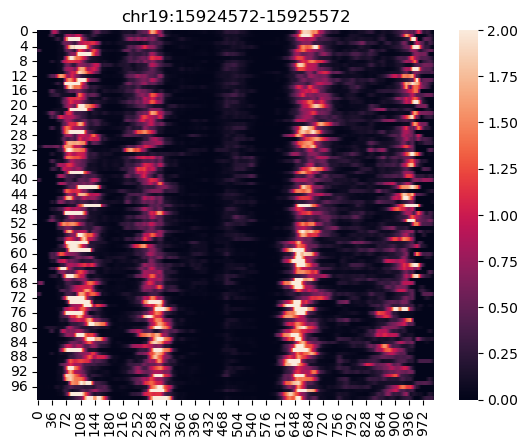

In [134]:
sns.heatmap(footprints[2, :, :], vmax=2)
plt.title(regions_str_filt[0])

In [241]:
tracking_results = {}

for region_ind in tqdm(np.arange(len(regions_str_filt))):

    # Retrieve region coordinates
    chr, start, end, id = regions_filt.iloc[region_ind, :]
    
    # First get aggregate signal across pseudo-bulks
    region_fp = footprints[region_ind, :, :]
    signal = np.mean(region_fp, axis=0)
    
    # Identify nucleosome positions by calling peaks in the footprint track
    nuc_pos_list, nuc_info = scipy.signal.find_peaks(signal, width=25, height=0.5)
    
    # For each nucleosome, record its summit coordinate and footprint score in each pseudo-bulk
    search_radius = 50
    for nuc_pos in nuc_pos_list:
        if (nuc_pos < search_radius) or (nuc_pos + search_radius + 1 > len(signal)):
            continue
        local_fp = region_fp[:, (nuc_pos - search_radius):(nuc_pos + search_radius)] 
        summit_pos = np.argmax(local_fp, axis=1) 
        summit_scores = local_fp[np.arange(len(summit_pos)), summit_pos]
        summit_pos = summit_pos - search_radius + nuc_pos + start
        tracking_results[id + "-" + str(nuc_pos)] = {
            "chr" : chr, "start" : start, "end" : end, region_ind : region_ind,
            "summit_pos" : summit_pos,
            "summit_scores" : summit_scores
        }

with open(tracking_results_path, "wb") as f:
    pickle.dump(tracking_results, f)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 31010/31010 [00:09<00:00, 3334.75it/s]


In [4]:
with open(tracking_results_path, "rb") as f:
    tracking_results = pickle.load(f)

In [28]:
for subpop_selection in ["Mk-biased", "multi-lineage", "all"]: 

    # Use all subpopulations or specific pairs (e.g., young mk-biased vs old mk-biased)
    if subpop_selection == "all":
        selection_mask = np.array([True for i in subpop_labels])
    else:
        selection_mask = np.array([bool(re.search(subpop_selection, i)) for i in subpop_labels])
    
    # Select young and old pseudobulks for comparison
    young_inds = np.logical_and(pbulk_age == "Young", selection_mask)
    old_inds = np.logical_and(pbulk_age == "Old", selection_mask)
    
    # Perform differential nucleosome testing
    diff_results = []
    for nucleosome in tqdm(tracking_results.keys()):
        summit_pos = tracking_results[nucleosome]["summit_pos"]
        summit_scores = tracking_results[nucleosome]["summit_scores"]
        pos_test = ss.ttest_ind(summit_pos[young_inds], summit_pos[old_inds])
        score_test = ss.ttest_ind(summit_scores[young_inds], summit_scores[old_inds])
        mean_diff_pos = np.mean(summit_pos[old_inds]) - np.mean(summit_pos[young_inds])
        mean_diff_score = np.mean(summit_scores[old_inds]) - np.mean(summit_scores[young_inds])
        diff_results.append([mean_diff_pos, pos_test.pvalue, np.mean(summit_scores), mean_diff_score, score_test.pvalue])
    
    # Compile results into a data frame
    diff_results = pd.DataFrame(
        diff_results, 
        index=tracking_results.keys(), 
        columns = ["mean_diff_pos", "pos_pval", "mean_score", "mean_diff_score", "score_pval"])
    diff_results.insert(0, "position", diff_results.index.values)
    
    # Save to file
    diff_results_path = os.path.join(
        main_path, "mHSCAging10xMultiome", \
        "diff_nucleosomes_" + subpop_selection + ".tsv"
    )
    diff_results.to_csv(diff_results_path, sep = "\t")

 18%|██████                            | 20394/114470 [00:17<01:18, 1198.67it/s]/home/yanhu/utils/miniforge3/envs/print/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
  5%|█▉                                 | 6241/114470 [00:05<01:30, 1194.54it/s]/home/yanhu/utils/miniforge3/envs/print/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  res = hypotest_fun_out(*samples, **kwds)
 20%|██████▉                           | 23377/114470 [00:19<01:15, 1199.96it/s]/home/yanhu/utils/miniforge3/envs/print/lib/python3.11/site-packages/scipy/stats/_axis_nan_policy.py:531: RuntimeWarning

In [256]:
diff_results.head()

,position,mean_diff_pos,pos_pval,mean_diff_score,score_pval
chr1:4496101-4497101-50,chr1:4496101-4497101-50,8.827499,0.010653,-0.263878,0.038285
chr1:4496101-4497101-197,chr1:4496101-4497101-197,1.342973,0.776580,-0.717079,0.000001
chr1:4496101-4497101-542,chr1:4496101-4497101-542,0.844242,0.865759,-0.186702,0.072860
chr1:4496101-4497101-787,chr1:4496101-4497101-787,-0.232877,0.965206,0.020658,0.902260
chr1:4571442-4572442-306,chr1:4571442-4572442-306,5.969559,0.281560,0.078367,0.331687


In [264]:
top_diff_sites = diff_results.loc[(abs(diff_results["mean_diff_score"]) > 2) & \
    (diff_results["score_pval"] < 1e-20), :]
top_diff_sites.to_csv("../../data/mHSCAging10xMultiome/diff_nucleosomes_top.tsv")
top_diff_sites